# Intelligent Placer and Checker (ML 2021)

In [1]:
# Постановка задачи

Требуется создать “Intelligent Placer”: по поданной на вход фотографии нескольких предметов на светлой горизонтальной поверхности и многоугольнику понимать, можно ли расположить одновременно все эти предметы на плоскости так, чтобы они влезли в этот многоугольник

У нас есть набор фотографий, на которые Placer ориентируется. Каждая фотография содержит 1 предмет (всего 10 предметов) на фоне белого листа A4.

Требования к этим фотографиям

- Белый лист занимает не менее 95% места на фотографии
- На фото только 1 объект
- Все объекты выпуклые
- Предмет и край листа А4 не пересекаются
- Источник света должен быть строго сверху над областью фотографирования
- Фотографировать нужно строго вертикально, не допускается наличие проекций предметов
- Рекомендуется фотографировать со вспышкой для избежания наличия теней
- Нет размытий, нет пикселей (не шакальное качество!) 

На вход алгоритма Placer подаётся фотография, на которой изображено несколько предметов и многоугольник, заданный набором координат (в миллиметрах) обходом против часовой стрелки.

Требования к этим фотографиям

- Вышеперечисленные критерии за исключением требования, что нужно фотографировать на листе А4. Подойдет светлый однотонный фон
- Предметы не пересекаются
- Каждый предмет целиком видно на фото
- На фото есть предметы только из тех 10, которые указаны в датасете для Placer (см. выше)
- Нет размытий, нет пикселей (не шакальное качество!)

Требования к многоугольнику
- Выпуклый
- Точки задаются в порядке обхода против часовой стрелки

Placer говорит, можно ли набор предметов уместить в многоугольник, то есть даёт ответ Y/N.


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import cv
import cv2
from imageio import imread, imsave
from skimage.feature import canny
from skimage.filters import gaussian
from skimage.color import rgb2gray
from skimage.util import img_as_ubyte
from skimage.filters import threshold_otsu, rank, try_all_threshold, threshold_li, threshold_local
from skimage.transform import (hough_line, hough_line_peaks, probabilistic_hough_line)
from matplotlib import cm
from matplotlib.patches import Rectangle
from scipy.ndimage.morphology import binary_fill_holes
from skimage.morphology import watershed, binary_erosion, binary_opening, disk, binary_closing


## Тест для произвольной фотки

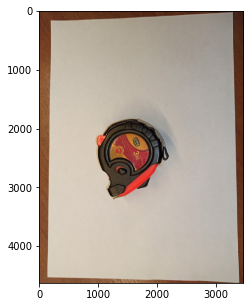

In [3]:
directory = "ML2021Dataset"

def read_image(filename):
    path = os.path.join(directory, filename)
    original_image = imread(path)
    return original_image

original_image = read_image("IMG_20210921_214051" + ".jpg")
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.imshow(original_image)

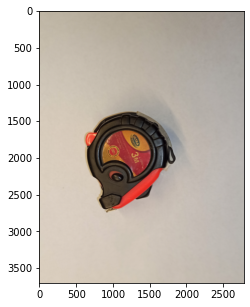

In [4]:
def cut_edges(original_image, cut_threshold):
    h, w, _ = original_image.shape
    cropped_image = original_image[(int)(h*cut_threshold):(int)(h*(1-cut_threshold)), (int)(w*cut_threshold):(int)(w*(1-cut_threshold))]
    return cropped_image

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
cropped_image = cut_edges(original_image, 0.1)
ax.imshow(cropped_image)

Попробуем предобработать изображение с помощью бинаризации:

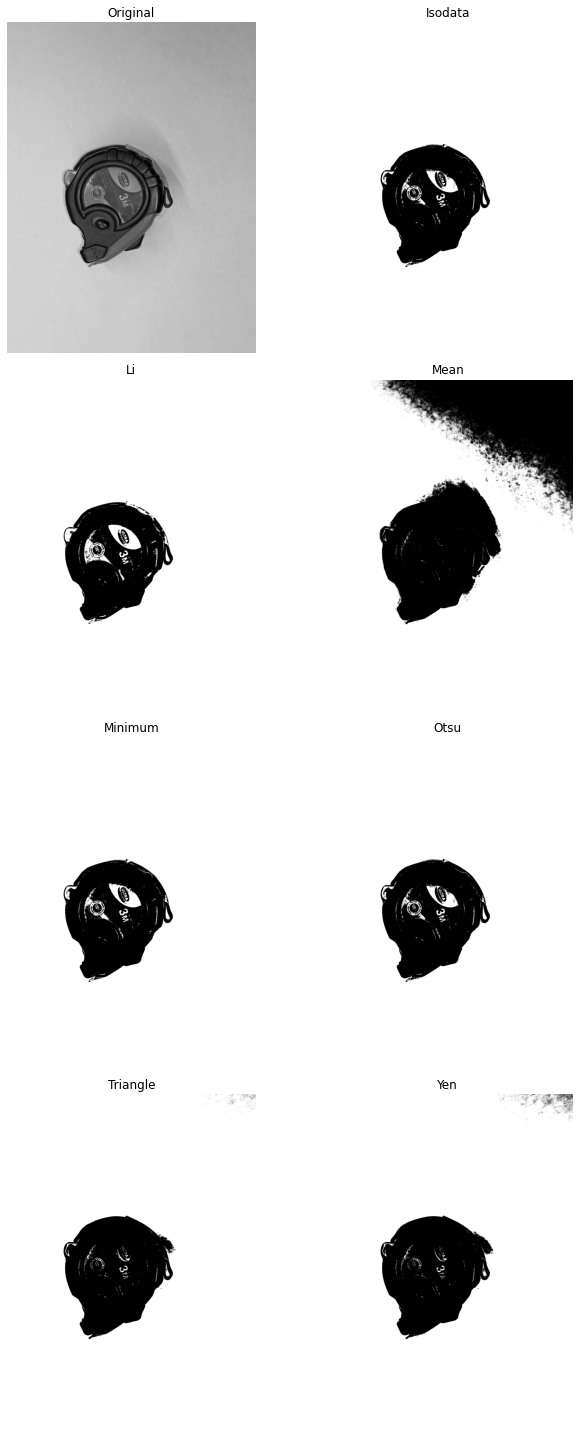

In [5]:
fig, ax = try_all_threshold(rgb2gray(cropped_image), figsize=(10, 20), verbose=False)
plt.show()

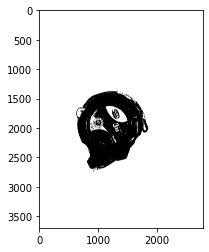

In [6]:
binary_gray = rgb2gray(cropped_image)
threshold = threshold_li(binary_gray)

ret, binary_image = cv2.threshold(binary_gray, threshold, 1, cv2.THRESH_BINARY)
#binary_image = binary_gray > threshold

plt.imshow(binary_image, cmap='gray')
plt.show()

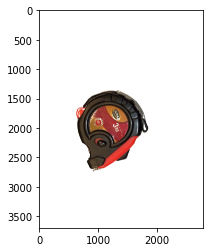

In [7]:
def crop_by_mask(src_image):
    image = src_image
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    #threshold = threshold_li(gray)
    threshold = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
    result = cv2.bitwise_and(image, image, mask=threshold)
    result[threshold==0] = [255,255,255]
    return result

result = crop_by_mask(cropped_image)
plt.imshow(result)

## Прогоним для всех фотографий

3


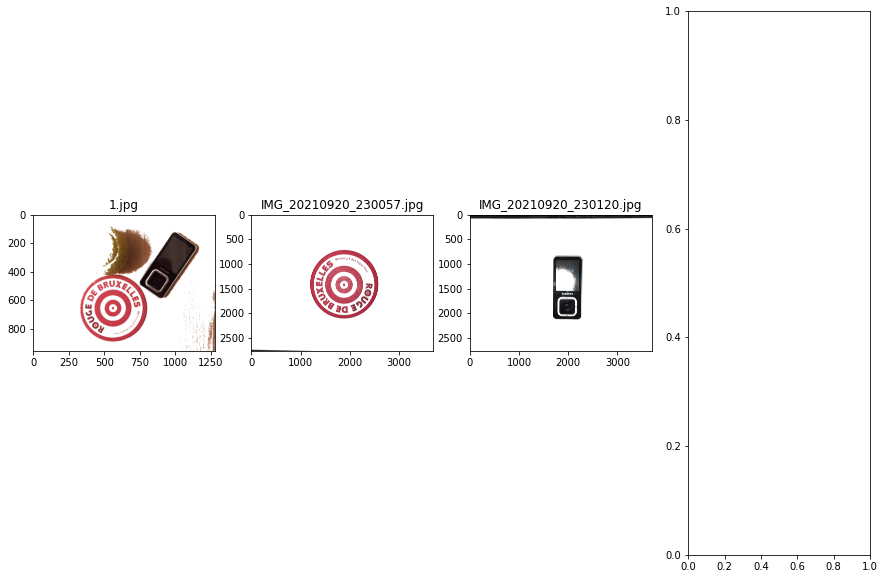

In [8]:
from os import listdir
from os.path import isfile, join

directory = "ML2021Dataset"

allFiles = [f for f in listdir(directory) if isfile(join(directory, f))]
allFiles = allFiles[0:3]
print(len(allFiles))

for i in range(len(allFiles)):
    count_in_raw = 4
    if (i % count_in_raw == 0):
        fig, ax = plt.subplots(1, count_in_raw, figsize=(15, 10))
    filename = allFiles[i]
    image = read_image(filename)
    image_cropped = cut_edges(image, 0.1)
    result = crop_by_mask(image_cropped)
    ax.flatten()[i%count_in_raw].set_title(filename)
    ax.flatten()[i%count_in_raw].imshow(result)

    
    

## Пробуем бороться с тенями

In [9]:
def get_rid_of_shadows(img):
    rgb_planes = cv2.split(img)

    result_planes = []
    result_norm_planes = []
    for plane in rgb_planes:
        dilated_img = cv2.dilate(plane, np.ones((7,7), np.uint8))
        bg_img = cv2.medianBlur(dilated_img, 21)
        diff_img = 255 - cv2.absdiff(plane, bg_img)
        norm_img = cv2.normalize(diff_img, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8UC1)
        result_planes.append(diff_img)
        result_norm_planes.append(bg_img)#norm_img)

    result = cv2.merge(result_planes)
    result_norm = cv2.merge(result_norm_planes)

    cv2.imwrite('shadows_out.png', result)
    cv2.imwrite('shadows_out_norm.png', result_norm)
    return result_norm

def crop_by_mask2(src_image):
    image = src_image
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    threshold = cv2.adaptiveThreshold(gray,255, cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY_INV,11,2)
    #threshold = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
    result = cv2.bitwise_and(image, image, mask=threshold)
    result[threshold==0] = [255,255,255]
    return result

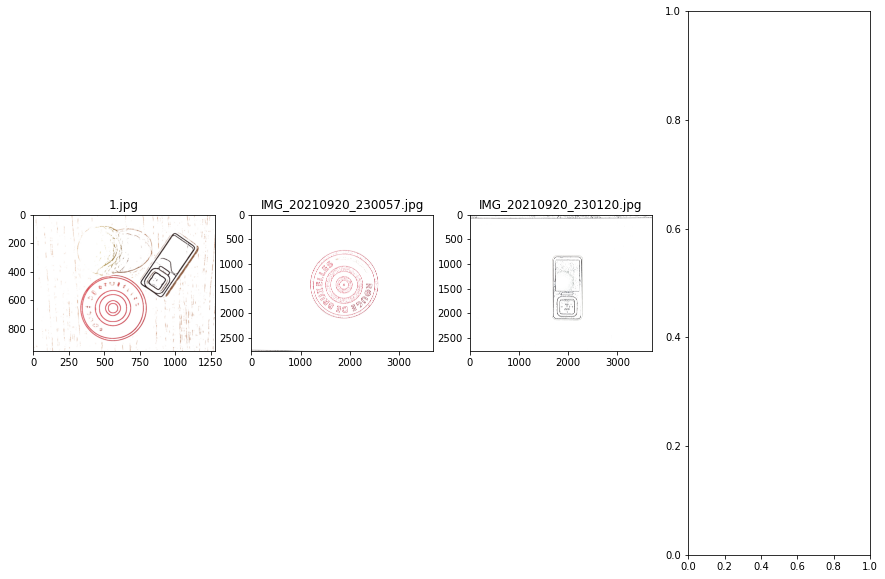

In [10]:

directory = "ML2021Dataset"
allFiles = [f for f in listdir(directory) if isfile(join(directory, f))]
allFiles = allFiles[0:3]
#print(len(allFiles))

for i in range(len(allFiles)):
    count_in_raw = 4
    if (i % count_in_raw == 0):
        fig, ax = plt.subplots(1, count_in_raw, figsize=(15, 10))
    filename = allFiles[i]
    image = read_image(filename)
    image = get_rid_of_shadows(image)
    image_cropped = cut_edges(image, 0.1)
    result = crop_by_mask2(image_cropped)
    ax.flatten()[i%count_in_raw].set_title(filename)
    ax.flatten()[i%count_in_raw].imshow(result)

можно будет использовать этот подход в placer, получить пиксели здесь, а потом выделить выпуклую оболочку для каждого предмета

## Пробуем строить выпуклую оболочку

In [11]:
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from collections import Counter
from random import sample

def make_pointList_from_2darray(arr):
    points = []
    for p in arr:
        points.append([p[0], p[1]])
    return points

def get_cluster_with_most_points(X):
    scaled_X = StandardScaler().fit_transform(X)
    # scaled_X = X
    clustering = DBSCAN(eps=0.3, min_samples=2).fit(scaled_X)
    #print(clustering.labels_)
    points = demo_plot(clustering, X)
    
    return points

def get_largest_cluster_label(cluster_labels):
    c = Counter(cluster_labels).most_common()[0]
    return c[0]

def get_point_array_from_hull(hull):
    lst = []
    for arr_point in hull:
        lst.append(arr_point[0])
    return np.array(lst)

def demo_plot(db, X):
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True
    labels = db.labels_
    largest_cluster_label = get_largest_cluster_label(labels)
    
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)
    # unique_labels = set(largest_cluster_label)
    # colors = [plt.cm.Spectral(each)
    #           for each in np.linspace(0, 1, len(unique_labels))]
    # for k, col in zip(unique_labels, colors):
        # if k == -1:
        #     # Black used for noise.
        #     col = [0, 0, 0, 1]
    col = [1, 0, 0, 1]
    class_member_mask = (labels == largest_cluster_label)

    xy = X[class_member_mask & core_samples_mask]

    hull = cv2.convexHull(xy)

    hull_points = get_point_array_from_hull(hull)
    
    plt.plot(hull_points[:, 0], hull_points[:, 1], 'o', markerfacecolor=tuple(col),
             markersize=5)

    # xy = X[class_member_mask & ~core_samples_mask]
    # plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
    #          markeredgecolor='b', markersize=3)

    plt.title('Estimated number of clusters: %d' % n_clusters_)
    plt.show()
    return hull_points

def convex_hull(src):
    image = src.copy()
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    all_points = []

    for x in range(image.shape[0]):
        for y in range(image.shape[1]):
            if image[x, y] != 255:
                all_points.append(np.array([y, -x]))
                
    print(len(all_points))
    
    part_of_points = sample(all_points, int(len(all_points) * 0.01))

    points = get_cluster_with_most_points(np.array(part_of_points))
    
    
    
    # convex_hull_points = cv2.convexHull(np.array(points))
    
#     result_image = image.copy()
#     for x in range(result_image.shape[0]):
#         for y in range(result_image.shape[1]):
#             result_image[x, y] = 0
      
#     for p in convex_hull_points:
#         x = p[0][0]
#         y = p[0][1]
#         w = 10
#         for u in range(x - w, x + w):
#             for v in range(y - w, y + w):
#                 if (u >= result_image.shape[0] or v >= result_image.shape[1] or u < 0 or v < 0):
#                     continue
#                 result_image[u,v] = 255      
        
    return points

3
79691


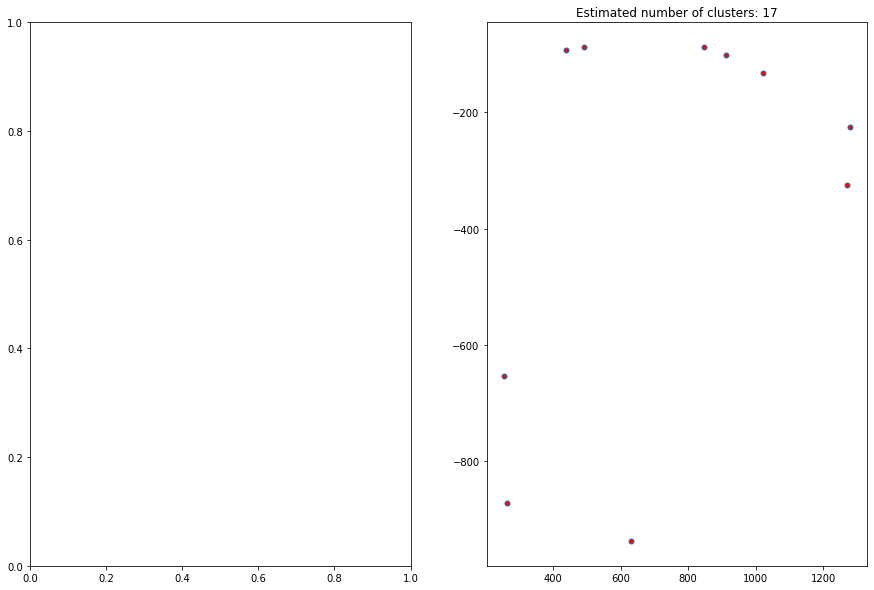

228712


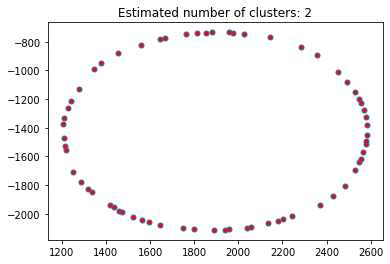

159649


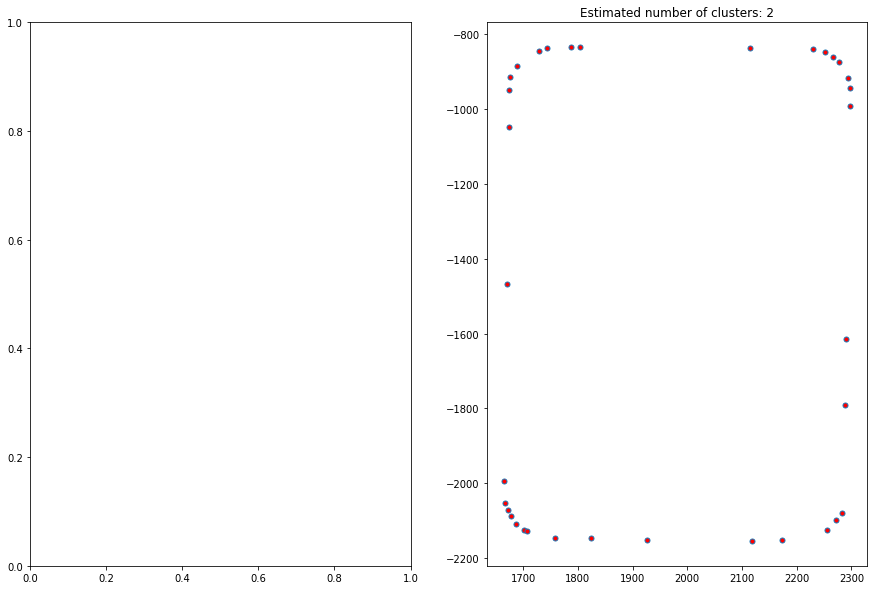

In [12]:
directory = "ML2021Dataset"
allFiles = [f for f in listdir(directory) if isfile(join(directory, f))]
allFiles = allFiles[0:3]
print(len(allFiles))

for i in range(len(allFiles)):
    count_in_raw = 2
    if (i % count_in_raw == 0):
         fig, ax = plt.subplots(1, count_in_raw, figsize=(15, 10))
    filename = allFiles[i]
    image_original = read_image(filename)
    image = get_rid_of_shadows(image_original)
    image_cropped = cut_edges(image, 0.1)
    result = crop_by_mask2(image_cropped)
    hull = convex_hull(result)
    
    height = image_original.shape[0]
    width = image_original.shape[1]
    mask = np.zeros((height, width), dtype=np.uint8)
    points = np.array([hull])
    cv2.fillPoly(mask, points, (255))
    res = cv2.bitwise_and(image_original,image_original,mask = mask)
    cv2.imwrite('image_masked.png', res)
    
    ax.flatten()[i%count_in_raw].set_title(filename)
    ax.flatten()[i%count_in_raw].imshow(res)

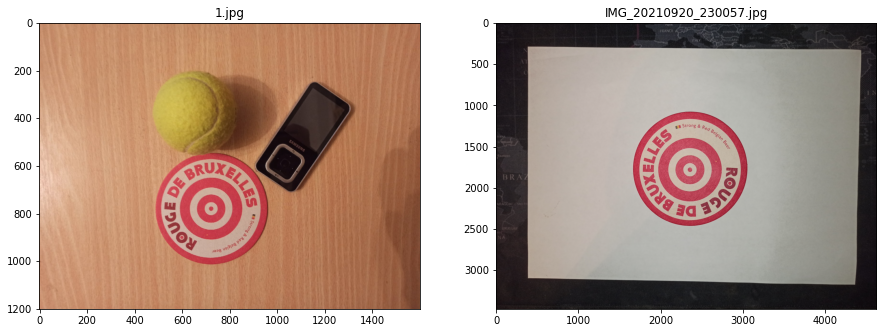

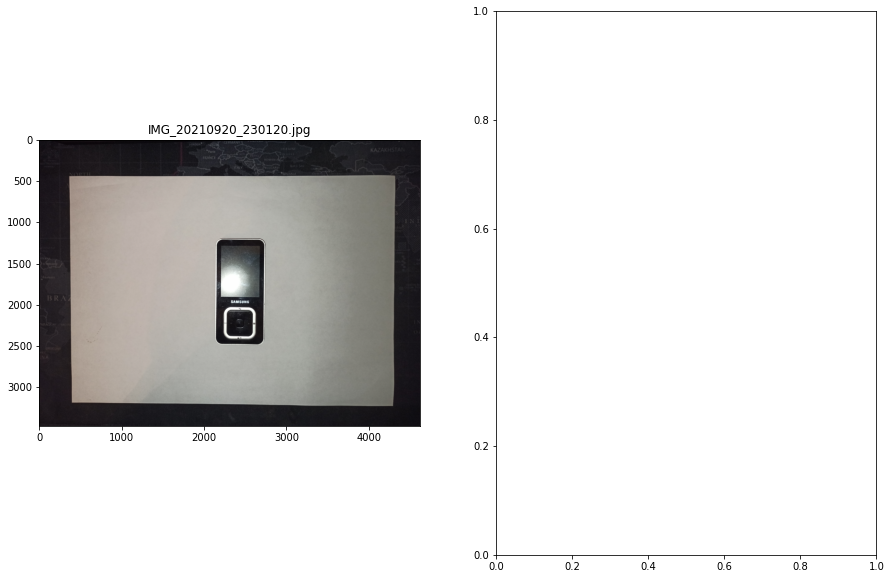

In [13]:
for i in range(len(allFiles)):
    count_in_raw = 2
    if (i % count_in_raw == 0):
        fig, ax = plt.subplots(1, count_in_raw, figsize=(15, 10))
    filename = allFiles[i]
    image = read_image(filename)
    ax.flatten()[i%count_in_raw].set_title(filename)
    ax.flatten()[i%count_in_raw].imshow(image)
plt.show()

In [14]:
print(hull)

[[ 2297  -946]
 [ 2294  -917]
 [ 2278  -874]
 [ 2267  -863]
 [ 2252  -849]
 [ 2229  -841]
 [ 2114  -837]
 [ 1804  -835]
 [ 1787  -835]
 [ 1744  -838]
 [ 1729  -845]
 [ 1689  -886]
 [ 1676  -916]
 [ 1675  -950]
 [ 1674 -1049]
 [ 1670 -1467]
 [ 1665 -1994]
 [ 1667 -2051]
 [ 1672 -2071]
 [ 1678 -2087]
 [ 1687 -2108]
 [ 1701 -2124]
 [ 1707 -2128]
 [ 1758 -2145]
 [ 1824 -2147]
 [ 1926 -2150]
 [ 2119 -2154]
 [ 2173 -2151]
 [ 2255 -2125]
 [ 2272 -2098]
 [ 2283 -2080]
 [ 2288 -1790]
 [ 2290 -1614]
 [ 2297  -992]]


In [15]:
def match_points_via_orb_detector(src, dst, good_match_threshold, verbose=True):   
    orb_detector = cv2.ORB_create(nfeatures=1000000)
    kp1, des1 = orb_detector.detectAndCompute(src, None)
    kp2, des2 = orb_detector.detectAndCompute(dst, None)

    matcher = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches = matcher.match(des1, des2)

    matches = sorted(matches, key=lambda x:x.distance)

    good_matches = []
    for m in matches:
        #print(m.distance)
        if m.distance < good_match_threshold:
            good_matches.append(m)
    
    print(len(good_matches))
    if len(good_matches) > 10:
        img_matches = cv2.drawMatches(src, kp1, dst, kp2, good_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
        plt.figure(figsize=(15, 15))
        plt.imshow(img_matches, interpolation='nearest')
        plt.show()
    
    return good_matches     


In [16]:
from os import listdir
from os.path import isfile, join

In [17]:
single_item_dataset_directory = "ML2021Dataset"
single_item_files = [f for f in listdir(single_item_dataset_directory) if isfile(join(single_item_dataset_directory, f))]
print(len(single_item_files))

57


In [18]:
placer_dataset_directory = "PlacerDataset"
placer_files = [f for f in listdir(placer_dataset_directory) if isfile(join(placer_dataset_directory, f))]
print(len(placer_files))

6


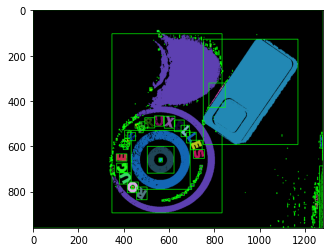

In [19]:
img = cv2.imread(join(placer_dataset_directory, placer_files[5]))
img = cut_edges(img, 0.1)
img = crop_by_mask(img)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
ret, bw = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

connectivity = 3
nb_components, output, stats, centroids = cv2.connectedComponentsWithStats(bw, connectivity, cv2.CV_32S)
sizes = stats[1:, -1]; nb_components = nb_components - 1
min_size = 250 #threshhold value for objects in scene

img2 = np.zeros((img.shape), np.uint8)
for i in range(0, nb_components+1):
    # use if sizes[i] >= min_size: to identify your objects
    color = np.random.randint(255,size=3)
    # draw the bounding rectangele around each object
    cv2.rectangle(img2, (stats[i][0],stats[i][1]),(stats[i][0]+stats[i][2],stats[i][1]+stats[i][3]), (0,255,0), 2)
    img2[output == i + 1] = color
plt.imshow(img2)

In [20]:
from random import randint, sample
from math import sqrt
from statistics import stdev

def find_dist(p1, p2):
    return sqrt( (p1[0]-p2[0])**2 + (p1[1]-p2[1])**2 )

def test_point(all_points, point):
    s = 0
    for p in all_points:
        s += find_dist(p, point)
    return s

def find_center(img, all_points, iteration_count):
    center = None
    height = img.shape[0]
    width = img.shape[1]
    min_sum = float('inf')
    for i in range(iteration_count):
        x = randint(0, height)
        y = randint(0, width)
        p = (x, y)
        sum = test_point(all_points, p)
        if sum < min_sum:
            min_sum = sum
            center = p
    return center, min_sum

def find_cluster(src, iteration_count):
    image = src
    #image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    all_points = []
    for x in range(image.shape[0]):
        for y in range(image.shape[1]):
            if image[x, y] == True:
                all_points.append([y, x])
                
    print(len(all_points))
    print(len(all_points) * iteration_count) 
        
    part_of_points = sample(all_points, int(len(all_points) * 0.01))
    
    print(len(part_of_points) * iteration_count) 
    
    center, sum_of_dist = find_center(image, part_of_points, iteration_count)
    
    all_dist = []
    for p in part_of_points:
        all_dist.append(find_dist(p, center))
        
    sigma = stdev(all_dist) 
    avg_dist = sum_of_dist / len(part_of_points)
    
    cluster_points = []
    for p in part_of_points:
        dist = find_dist(p, center)
        if dist < 5 * sigma:
            cluster_points.append(p)
    return cluster_points

def convex_hull_simple(src, iteration_count=1000):
    points = find_cluster(src, iteration_count)
    convex_hull_points = cv2.convexHull(np.array(points))
    return convex_hull_points

6
18767
9383500
93500


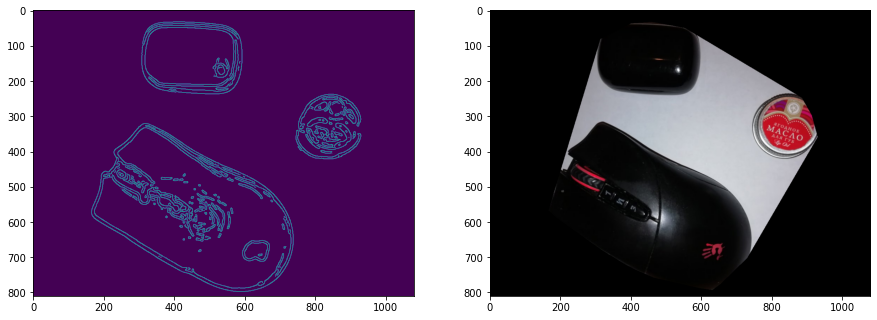

40985
20492500
204500


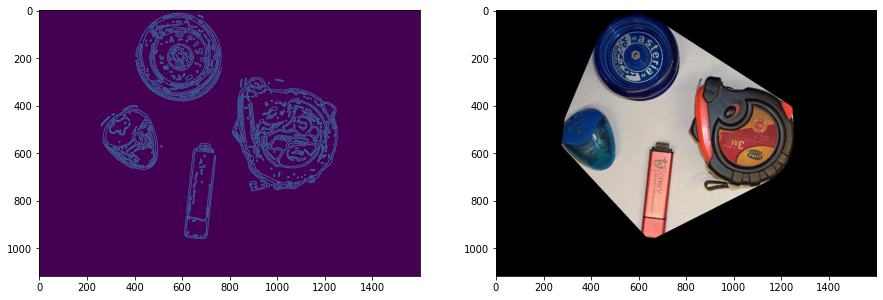

40743
20371500
203500


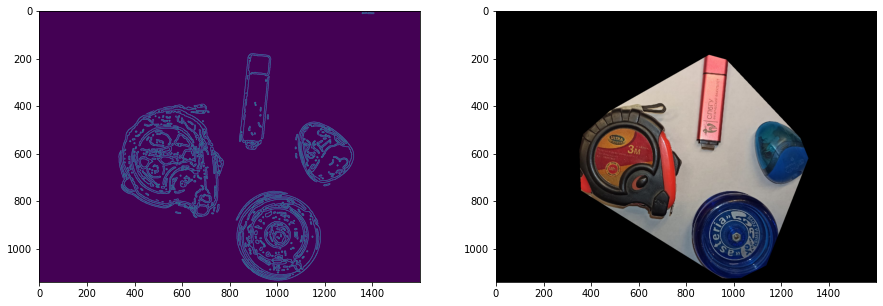

40038
20019000
200000


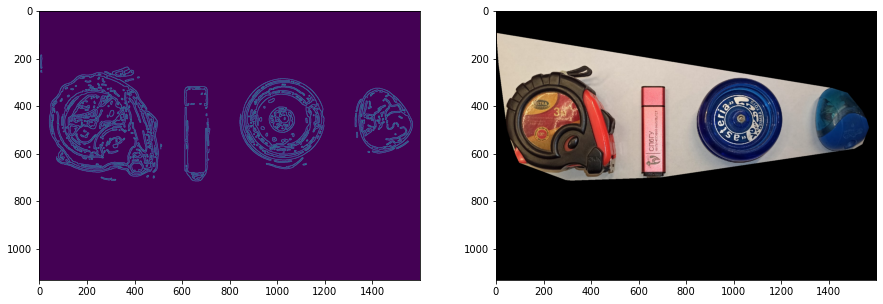

42293
21146500
211000


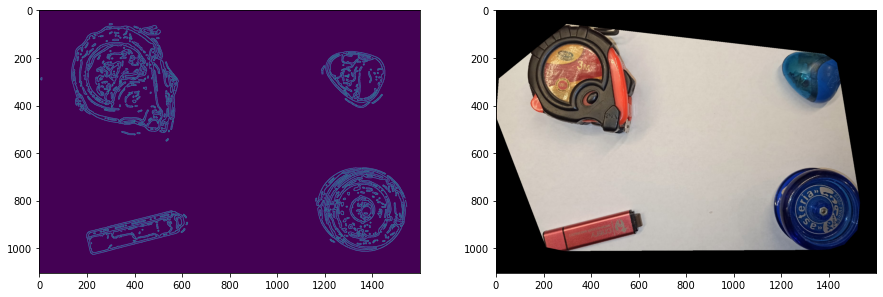

62174
31087000
310500


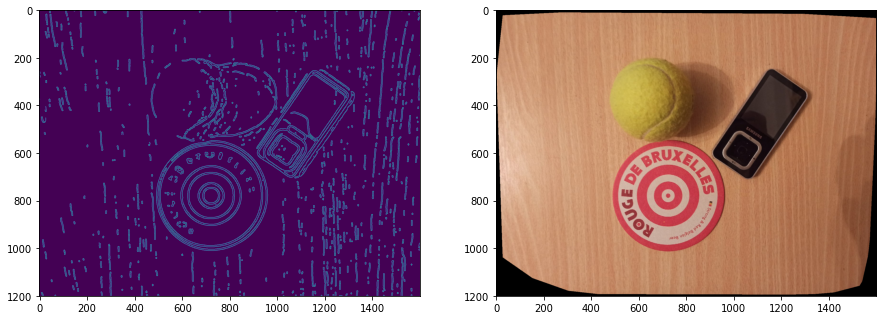

In [21]:
# directory = "ML2021Dataset"
directory = "PlacerDataset"
allFiles = [f for f in listdir(directory) if isfile(join(directory, f))]
#allFiles = allFiles[0:2]
print(len(allFiles))

for i in range(len(allFiles)):
    
    fig, ax = plt.subplots(1, count_in_raw, figsize=(15, 10))
    
    filename = allFiles[i]
    image_original = read_image(filename)
    image_cropped = cut_edges(image_original, 0)
    image = get_rid_of_shadows(image_cropped)
    
    result = crop_by_mask2(image)
    
    result = canny(cv2.cvtColor(result, cv2.COLOR_BGR2GRAY), sigma=2)
    
    ax.flatten()[0].imshow(result)
    hull = convex_hull_simple(result,500)
    
    height = image_cropped.shape[0]
    width = image_cropped.shape[1]
    mask = np.zeros((height, width), dtype=np.uint8)
    points = np.array([hull])
    cv2.fillPoly(mask, points, (255))
    res = cv2.bitwise_and(image_cropped, image_cropped,mask = mask)
    
    ax.flatten()[0].imshow(result)
    ax.flatten()[1].imshow(res) 
    plt.show()

# Пробуем выделять отдельные объекты, а затем классифицировать

3
PlacerDataset\1.jpg
PlacerDataset\2.jpg
PlacerDataset\3.jpg


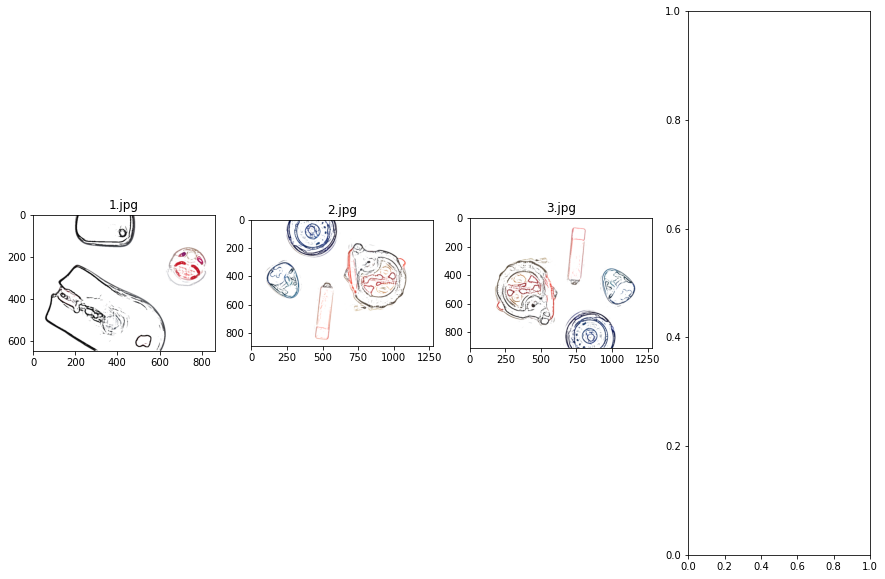

In [22]:
from os import listdir
from os.path import isfile, join

directory = "PlacerDataset"
allFiles = [f for f in listdir(directory) if isfile(join(directory, f))]
allFiles = allFiles[0:3]
print(len(allFiles))

for i in range(len(allFiles)):
    count_in_raw = 4
    if (i % count_in_raw == 0):
        fig, ax = plt.subplots(1, count_in_raw, figsize=(15, 10))
    filename = allFiles[i]
    print(join(directory, filename))
    image = read_image(filename)
    image = get_rid_of_shadows(image)
    image_cropped = cut_edges(image, 0.1)
    result = crop_by_mask2(image_cropped)
    ax.flatten()[i%count_in_raw].set_title(filename)
    ax.flatten()[i%count_in_raw].imshow(result)

In [132]:
from __future__ import print_function
import numpy as np
import argparse
import random as rng
rng.seed(12345)

def thresh_callback(src, threshold):
    src_gray = cv2.cvtColor(src, cv2.COLOR_BGR2GRAY)
    src_gray = cv2.blur(src_gray, (3,3))

    max_thresh = 255
    # cv2.createTrackbar('Canny thresh:', "source_window", threshold, max_thresh, thresh_callback)

    canny_output = cv2.Canny(src_gray, threshold, threshold * 2)
    
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (15, 15))
    closed = cv2.morphologyEx(canny_output, cv2.MORPH_CLOSE, kernel)
    
    contours, hierarchy = cv2.findContours(closed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # contours = filter(lambda cont: cv2.arcLength(cont, False) > 10, contours)
    
    contours_poly = [None]*len(contours)
    boundRect = [None]*len(contours)
    centers = [None]*len(contours)
    radius = [None]*len(contours)
    index = -1
    for i, c in enumerate(contours):
        index += 1
        if ( cv2.arcLength(c, False) < 500):
            continue
        contours_poly[index] = cv2.approxPolyDP(c, 3, True)
        boundRect[index] = cv2.boundingRect(contours_poly[index])
        centers[index], radius[index] = cv2.minEnclosingCircle(contours_poly[index])

    
    drawing = np.zeros((canny_output.shape[0], canny_output.shape[1], 3), dtype=np.uint8)
    
    hierarchy = hierarchy[0]
    print("Общее Количество контуров", len(contours))
    counter = 0

    color = [(255, 44, 0),
         (254, 178, 0),
         (161, 238, 0),
         (129, 6, 168),
         (0, 165, 124),
         (18, 62, 170),
]
    cropped_objects = []
    for i, c in enumerate(contours):
        if ( cv2.arcLength(c, False) < 500):
            continue
        counter += 1
        if hierarchy[i][2] < 0 and hierarchy[i][3] < 0:
            cv2.drawContours(drawing, contours, i, color[counter], 2)
        else:
            cv2.drawContours(drawing, contours, i, (0, 255, 0), 2)
            
        y, x, h, w, = boundRect[i]
        cropped_objects.append(src[(int)(x):(int)(x+w), (int)(y):(int)(y+h)])
    print("Длинное Количество контуров", counter)
    
    # x,y,w,h 
    
    return drawing, cropped_objects

6
Общее Количество контуров 3
Длинное Количество контуров 3
Общее Количество контуров 8
Длинное Количество контуров 4
Общее Количество контуров 4
Длинное Количество контуров 4
Общее Количество контуров 5
Длинное Количество контуров 5
Общее Количество контуров 7
Длинное Количество контуров 5
Общее Количество контуров 2
Длинное Количество контуров 2


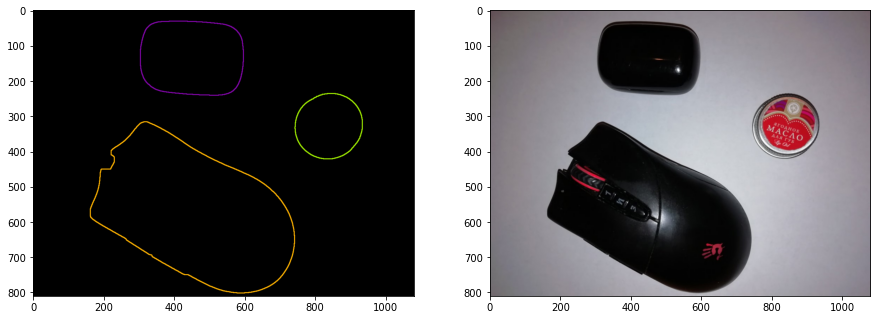

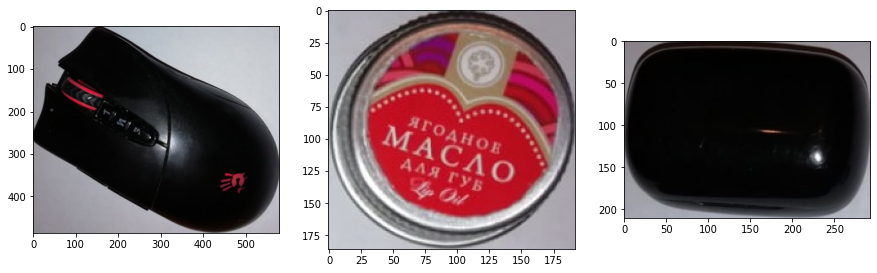

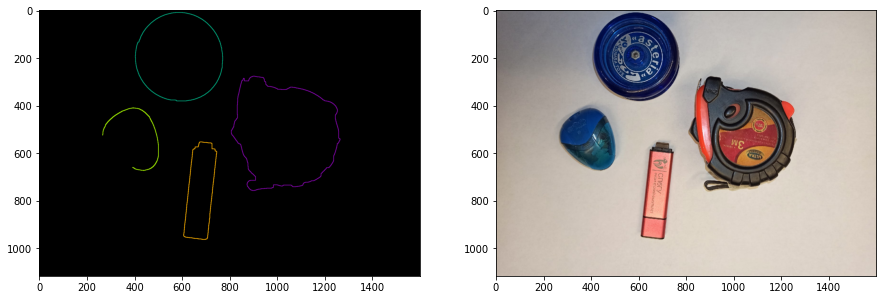

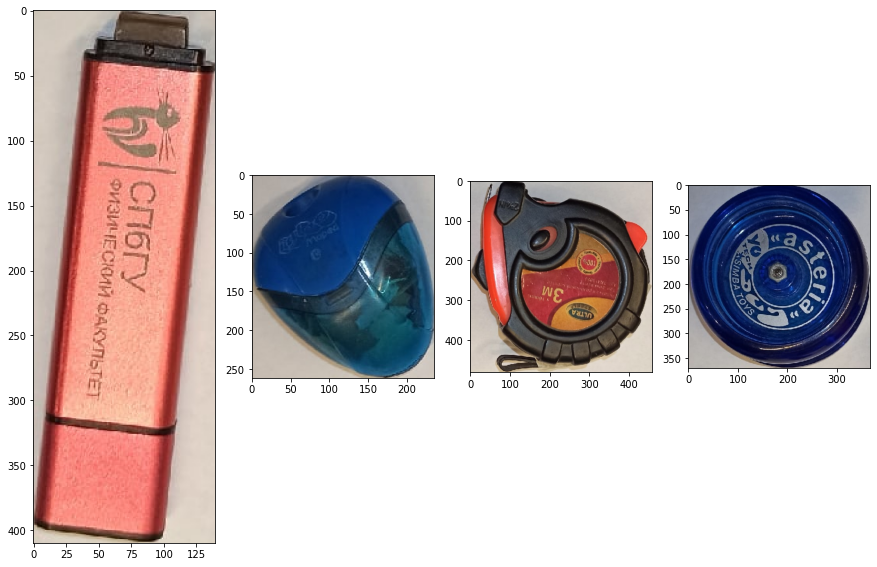

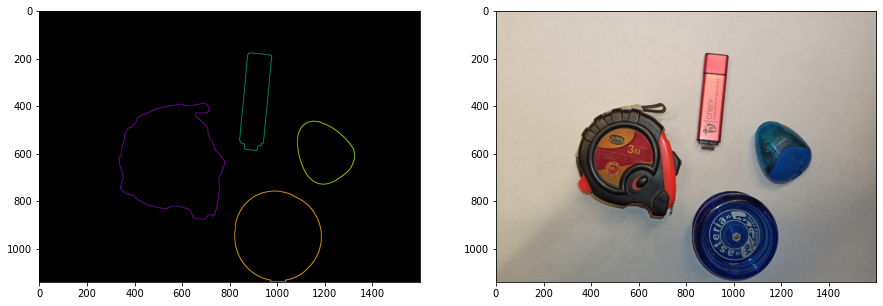

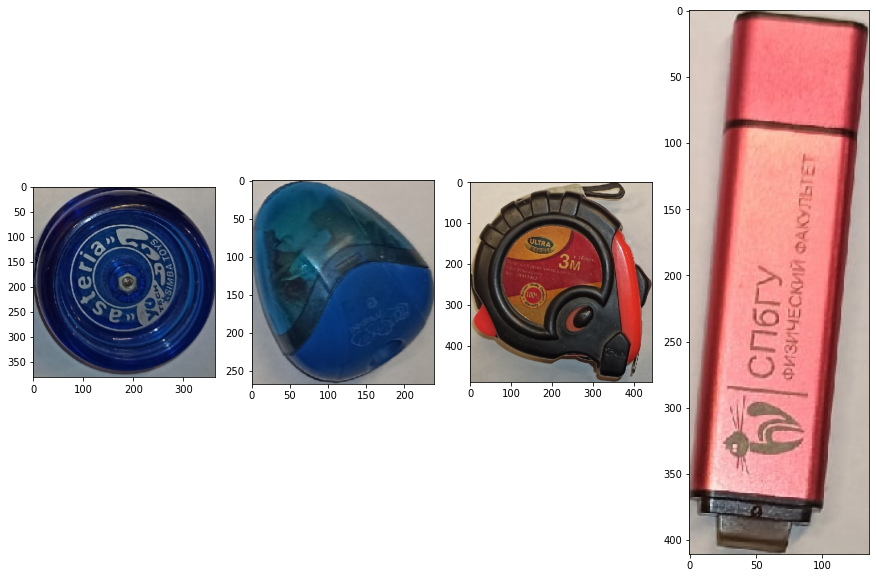

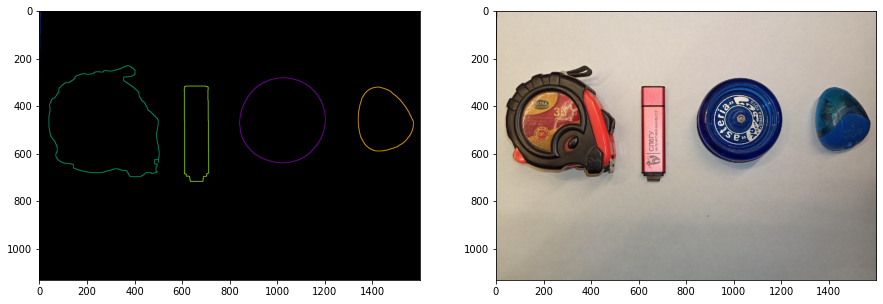

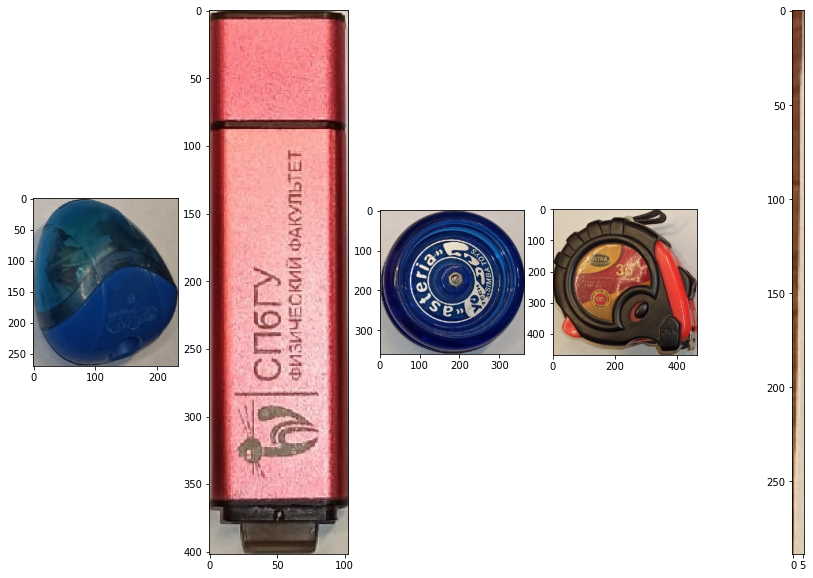

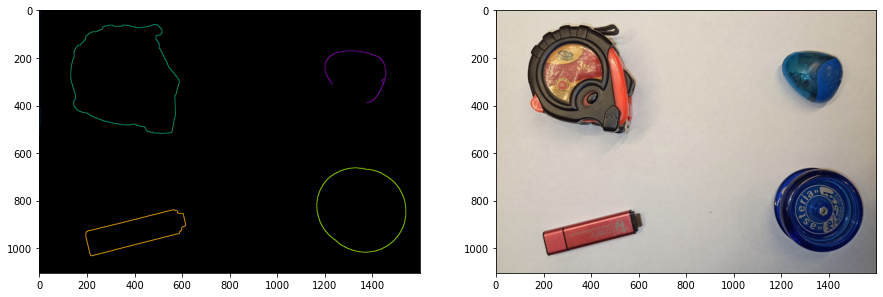

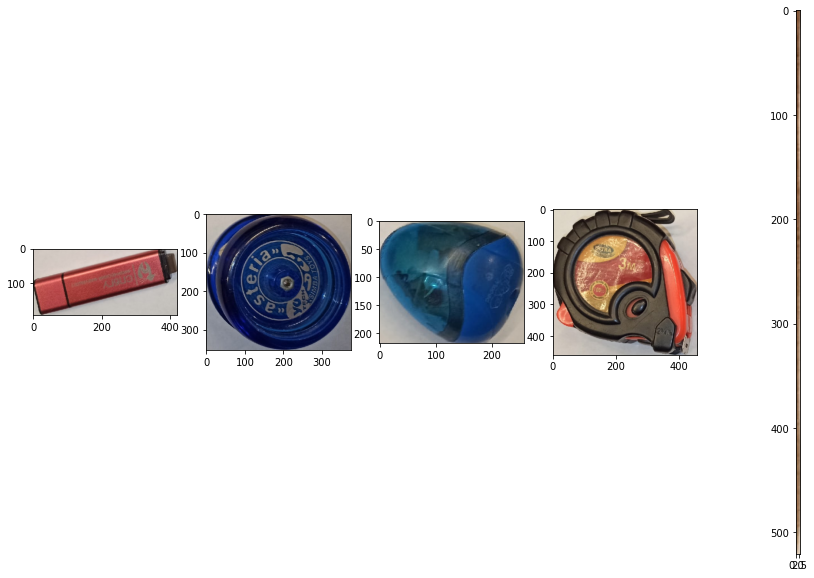

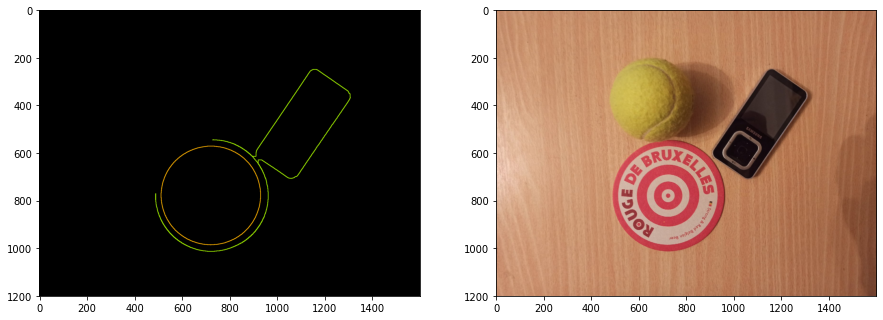

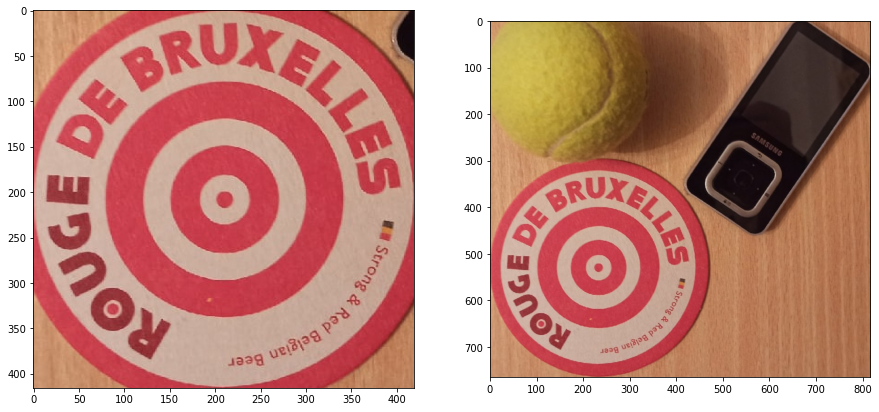

In [133]:
from os import listdir
from os.path import isfile, join

directory = "PlacerDataset"

allFiles = [f for f in listdir(directory) if isfile(join(directory, f))]
#allFiles = allFiles[0:3]
print(len(allFiles))

thresh = 100

for i in range(len(allFiles)):
    
    fig, ax = plt.subplots(1, 2, figsize=(15, 10))
    
    filename = allFiles[i]
    image = read_image(filename)
    #image = crop_by_mask(image)
   
    result, cropped_objects = thresh_callback(image, thresh)

    ax.flatten()[0].imshow(result)
    ax.flatten()[1].imshow(image)    
    
    fig1, ax1 = plt.subplots(1, len(cropped_objects), figsize=(15, 10))
    for i, image in enumerate(cropped_objects):
        ax1.flatten()[i].imshow(image)

##Допустим, 